In [ ]:
#| hide
from nbdev import *

# OUScope

> The `ouscope` is a library providing python interface to the Open University Autonomous Robotic Telescope facility at telescope.org

The library provides access and control for the telescope. The functions help with job submission, image retrival and initial analysis. For naw this is aimed at variable star observations, but there is nothing prohibiting additional modules intended for different fields (e.g. astrometry).

## Install

The package is not yet published to pypi/conda, thus for now the only way to install it is the developer-style install. I recommend the following sequence:

```bash
git clone https://github.com/jochym/ouscope.git
cd ouscope
python3 -m venv venv 
. venv/bin/activate

pip install -e .
```

Later on you just go to the ouscope directory and run:
```bash
. venv/bin/activate
```
to activate the virtual environment.

### Update
With developer install the upgrade is simple, `git pull` should do the trick :
```bash
cd ouscope
git pull
```
When the set of dependecies changes you may need to
```bash
pip uninstall ouscope ; pip install -e .
```

to refresh your setup.

## How to use

The library is not ready but you can try to use it for some tasks. Before this example will run you need to have some additional setup:

- Local AstrometryNet solver (`solve-field` command) installed and configured. It is possible to use nova.astrometry.net solver but the automatic interaction/switching is not complete yet. You can modify the example to use it (see `Solver` docs for some guidance)
- The config file for your telescope.org account. The cache directories will be created in the current working directory with this setup. You may move them to some other place (e.g. `~/.cache/ouscope`):
```
[cache]
wcs=.cache/wcs
jobs=.cache/jobs
seq=.cache/seq

[telescope.org]
user=jour_user_name
password=your_password

[astrometry.net]
apikey=your_astrometry.net_api_key

```

If it still does not work, please submit a github issue. I do not have many systems to test the library on. Below is a simple example.

### Interacting with telescope.org

The code below:
- creates the `Telescope` object `scope`
- automatically logs-in to the user from the config file
- lists user folders
- gets user requests sorted by request ID (i.e. submission order)
- goes over the list until five completed requests are listed
- downloads the latest completed job into `obs` variable
- prints JobID:RequestID, target name, 

In [ ]:
#| login
#|code-fold: true
from ouscope.core import Telescope

scope=Telescope(config='~/.config/telescope.ini')

print("User folders:")
for f in scope.get_user_folders():
    cnt = f["count"] 
    if cnt is None:
        cnt = 0
    print(f'{f["name"]:>12} ({f["id"]:>3}): {cnt:>4} items')

reqlst=scope.get_user_requests(sort='rid')

print(f'\nUser {scope.user} has {len(reqlst)} requests.')
print("\nThe most recent requests:")
last_complete = None
complete = []
n = 10
for rq in reqlst:
    jid = scope.get_jid_for_req(rq)
    print(f'{rq["id"]}: {rq["objectname"]:15} jid: {(jid if jid else ""):6}', end=' ')
    print(f'{Telescope.REQUESTSTATUS_TEXTS[int(rq["status"])]}')
    if rq["status"]=='8':
        complete.append(jid)
        if last_complete is None:
            last_complete = jid
        n -= 1
    if n<0 :
        break
print()

jid = complete[6]
# Let us show the newest job
job = scope.get_job(int(jid))
req = scope.get_request(int(job['rid']))
target = req['name'].lstrip().rstrip()

print('The latest complete job:')
print(f'J{jid}:R{job["rid"]} ({target}) Completed at: {" ".join(job["completion"])}')

obs = scope.get_obs(job, verbose=True)

scope.logout()

User folders:
       Inbox (  1): 1849 items
  Favourites (  2):    0 items
     Archive (  3):  447 items
       Trash (  4):   63 items
    Complete (461):   13 items

User jochym has 1849 requests.

The most recent requests:
771981: EQ Lyr          jid:        Waiting
771980: DQ Vul          jid:        Waiting
771979: DX Vul          jid:        Waiting
771978: V686 Cyg        jid:        Waiting
771977: IP Cyg          jid:        Waiting
771976: SS Cyg          jid:        Waiting
771975: CH Cyg          jid:        Waiting
771974: V1223 Sgr       jid:        Waiting
771144: LX Cyg          jid: 422672 Complete
771143: EQ Lyr          jid: 422671 Complete
771142: DQ Vul          jid: 422670 Complete
771141: DX Vul          jid: 422669 Complete
771140: BI Her          jid:        Waiting
771139: V686 Cyg        jid: 422667 Complete
771138: IP Cyg          jid: 422666 Complete
771137: SS Cyg          jid: 422665 Complete
771136: CH Cyg          jid: 422664 Complete
771135: T CrB   

### Analysis of the data

Let us plot and analyse the last completed job listed above.  
The code below performs following tasks:

- opens the data downloaded above (`obs` variable)
- plate-solves the resultings fits data (with local AstrometryNet solver)
- creates WCS object from the solution
- plots the RGB image of the data with RA-DEC grid
- query the Vizier database for variable stars 0.25 deg from center
- mark all objects found on the picture

In [ ]:
#|code-fold: true
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.vizier import Vizier
import matplotlib.pyplot as plt
from ouscope.solver import Solver
from ouscope.process import make_color_image

In [ ]:
#| login
#|code-fold: true
solver = Solver()

hdu = fits.open(obs)[0]

wcs_head = solver.solve(hdu, tout=30)
wcs = WCS(wcs_head, naxis=2)
wcs.printwcs()

Getting 3FC31541 from cache
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP' 'DEC--TAN-SIP' 
CRVAL : 325.664456137 43.3443615705 
CRPIX : 792.579582214 218.743708611 
CD1_1 CD1_2  : -0.000467545013261 -7.21595587477e-06 
CD2_1 CD2_2  : -6.87748343483e-06 0.000467154442828 
NAXIS : 1536  1536  3


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


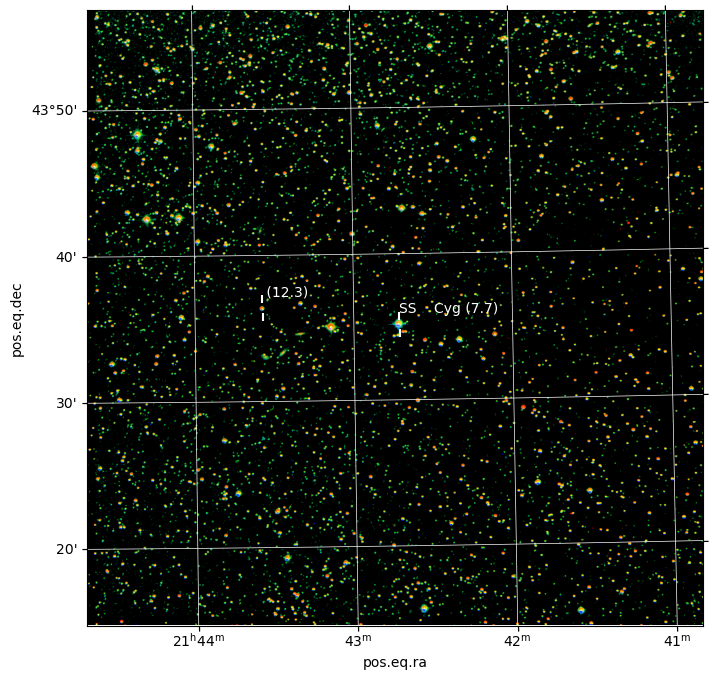

In [ ]:
#| login
#|code-fold: true
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(projection=wcs)
plt.grid(color='white', ls='solid', lw=0.5)

# crop the data to remove overscan noise
l, r, t, b = (0, 32, 0, 32)
plt.imshow(make_color_image(hdu.data[:, l:-r, t:-b],
                            order=hdu.header["FILTER"].split(",")))

center = wcs.pixel_to_world(wcs_head['NAXIS1']/2,wcs_head['NAXIS2']/2)
objects = Vizier.query_region(catalog='B/gcvs', 
                             coordinates=center, 
                             radius='0.25deg')
for g in objects:
    for n, o in enumerate(g):
        name = o['VarName']
        radec = SkyCoord(o['RAJ2000'] + o['DEJ2000'], 
                         frame='icrs', unit=(u.hourangle, u.deg))
        ax.scatter([radec.ra.deg, radec.ra.deg], 
                   [radec.dec.deg-0.01, radec.dec.deg+0.01], 
                   marker='|', s=30,
                   color='white',
                   transform=ax.get_transform('world'))
        ax.text(radec.ra.deg, radec.dec.deg+0.014, 
                f'{name} ({o["magMax"]:.1f})', 
                transform=ax.get_transform('world'), color='white')           




### List of objects (variable stars) in the frame 

In [ ]:
#|echo: false 
#|login
objects[0]

GCVS,n_GCVS,RAJ2000,DEJ2000,VarType,magMax,Period,SpType,Exists,VarName,Simbad
,,,,,mag,d,,,,
str10,str1,str11,str11,str10,float32,float64,str17,str12,str11,str6
SS Cyg,*,21 42 42.79,+43 35 09.9,UGSS,7.700,49.5000000000,K5V+pec(UG),,SS Cyg,Simbad
